In [1]:
import numpy as np
from math import pi
import random
from astropy.io import fits
import pandas as pd
import os
from tqdm import tqdm
import utils
#from joblib import Parallel, delayed
import multiprocessing
import time
import glob
import argparse
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import regionprops, label
from skimage.feature import blob_dog
from casatasks import simanalyze,  simobserve, tclean, exportfits, simalma
from astropy.visualization import simple_norm
from astropy.io import fits
from astropy.wcs import WCS
from astropy import constants as c
from skimage.measure import regionprops, label
from casatasks import simanalyze,  simobserve, tclean, exportfits, simalma
from astropy.visualization import simple_norm
from photutils.aperture import CircularAnnulus, CircularAperture

In [5]:
def threedgaussian(amplitude, spind, chan, center_x, center_y, width_x, width_y, angle, idxs):
    angle = pi/180. * angle
    rcen_x = center_x * np.cos(angle) - center_y * np.sin(angle)
    rcen_y = center_x * np.sin(angle) + center_y * np.cos(angle)
    xp = idxs[0] * np.cos(angle) - idxs[1] * np.sin(angle)
    yp = idxs[0] * np.sin(angle) + idxs[1] * np.cos(angle)
    v1 = 230e9
    v2 = v1+10e6*chan

    g = (10**(np.log10(amplitude) + (spind) * np.log10(v1/v2))) * np.exp(-(((rcen_x-xp)/width_x)**2+((rcen_y-yp)/width_y)**2)/2.)
    return g


def gaussian(x, amp, cen, fwhm):
    """
    Generates a 1D Gaussian given the following input parameters:
    x: position
    amp: amplitude
    fwhm: fwhm
    level: level
    """
    return amp*np.exp(-(x-cen)**2/(2*(fwhm/2.35482)**2))


def generate_gaussian(amp, line_amp, data_dir, i):
    idxs = np.indices([360, 360])
    z_idxs = np.linspace(0, 128, 128)
    line_cent = 64
    pa = 0
    pos_x, pos_y = 180, 180
    fwhm_x, fwhm_y = 3, 3
    line_fwhm = 6
    spidx = 0
    cube = np.zeros([128, 360, 360])
    for z in range(cube.shape[0]):
        temp_source =  threedgaussian(amp, spidx, z, pos_x, pos_y, fwhm_x, fwhm_y, pa, idxs)
        cube[z, :, :] += temp_source
        cube[z, :, :] += gaussian(z_idxs, line_amp, line_cent, line_fwhm)[z] * temp_source
    hdu = fits.PrimaryHDU(data=cube.astype(np.float32))
    hdu.writeto(data_dir + '/gauss_cube_' + str(i) + '.fits', overwrite=True)

    img = np.sum(cube, axis=0)
    norm = simple_norm(img, 'sqrt')
    max_ = np.max(img)
    std = np.std(img)
    tseg = img.copy()
    tseg[tseg >= 3 * std] = 1
    tseg = tseg.astype(int)
    props = regionprops(label(tseg, connectivity=2))
    y0, x0, y1, x1 = props[0].bbox
    
    spectrum = np.sum(cube[:, 128 - 6: 128 + 6, 128 - 6: 128 + 6], axis=(1, 2))
    fig, ax = plt.subplots(figsize=(16, 8), nrows=1, ncols=2)
    im0 = ax[0].imshow(img, origin="lower", cmap="magma", norm=norm)
    ax[0].set_title("Model Cube, max value {}".format(round(max_, 2)))
    rect = patches.Rectangle(xy=(x0, y0), 
                width=x1 - x0,
                height=y1 - y0,
                facecolor="none",
                edgecolor='green')
    ax[0].add_patch(rect)
    plt.colorbar(im0, ax=ax[0])
    ax[1].plot(spectrum)
    plt.show()
    return np.array([y0, x0, y1, x1])
    

def simulator_tclean(output_dir, filename, project, amp, line_amp, box):
    antennalist = "alma_cycle9_configuration_files/alma.cycle9.3.cfg"
    simobserve(
        project=project, 
        skymodel=filename,
        inbright="0.001Jy/pix",
        indirection="J2000 03h59m59.96s -34d59m59.50s",
        incell="0.05arcsec",
        incenter="230GHz",
        inwidth="10MHz",
        setpointings=True,
        integration="10s",
        direction="J2000 03h59m59.96s -34d59m59.50s",
        mapsize=["10arcsec"],
        maptype="hexagonal",
        obsmode="int",
        antennalist=antennalist,
        totaltime="2400s",
        thermalnoise="tsys-atm",
        user_pwv=0.8,
        seed=11111,
        graphics="none",
        verbose=False,
        overwrite=True)

    tclean(
        vis=os.path.join(project, "{}.alma.cycle9.3.noisy.ms".format(project)),
        imagename=project+'/{}.alma.cycle9.3'.format(project),
        imsize=[360, 360],
        cell=["0.05 arcsec"],
        phasecenter="",
        specmode="cube",
        niter=0,
        fastnoise=False,
        calcpsf=True,
        pbcor=False
    )
    exportfits(imagename=project+'/{}.alma.cycle9.3.image'.format(project), 
           fitsimage=output_dir +'/dirty_cube_tclean_{}_{}.fits'.format(amp, line_amp))
    exportfits(imagename=project+'/{}.alma.cycle9.3.skymodel'.format(project), 
           fitsimage=output_dir +'/clean_cube_tclean_{}_{}.fits'.format(amp, line_amp))
    
    data = fits.getdata(output_dir +'/dirty_cube_tclean_{}_{}.fits'.format(amp, line_amp))[0]
    img = np.sum(data, axis=0)
    norm = simple_norm(img, 'sqrt')
    
    y0, x0, y1, x1 = box
    xc, yc = 180, 180
    r0, r1 = 1.6 * (x1 - x0), 2.6 * (x1 - x0)
    r = 0.5 * (x1 - x0)

    noise_aperture = CircularAnnulus((xc, yc), r0 / 2, r1 / 2 )
    mask = noise_aperture.to_mask(method='center')

    source_aperture = CircularAperture((xc, yc), r)
    aperture_mask = source_aperture.to_mask()

    noise_p = mask.multiply(img)
    noise_p = noise_p[mask.data > 0]
    source_p = aperture_mask.multiply(img)
    source_p = source_p[aperture_mask.data > 0.]
    std = np.std(noise_p)
    mean = np.mean(source_p)
    snr = mean / std
    return snr


def simulator_simalma(output_dir, filename, project, amp, line_amp, box):
    antennalist = "alma_cycle9_configuration_files/alma.cycle9.3.cfg"
    simalma(
        project=project,
        dryrun=False,
        skymodel=filename,
        inbright="0.001Jy/pix",
        indirection="J2000 03h59m59.96s -34d59m59.50s",
        incell="0.05arcsec",
        incenter="230GHz",
        inwidth="10MHz",
        antennalist=antennalist,
        totaltime="2400s",
        mapsize=["10arcsec"],
        pwv=0.8,
        niter=0,
        imsize=[360, 360],
        overwrite=True,
        verbose=False
    )
    exportfits(imagename=project+'/{}.alma.cycle9.3.noisy.image'.format(project), 
           fitsimage=output_dir +'/dirty_cube_simalma_{}_{}.fits'.format(amp, line_amp))
    exportfits(imagename=project+'/{}.alma.cycle9.3.skymodel'.format(project), 
           fitsimage=output_dir +'/clean_cube_simalma_{}_{}.fits'.format(amp, line_amp))
    data = fits.getdata(output_dir +'/dirty_cube_simalma_{}_{}.fits'.format(amp, line_amp))[0]
    img = np.sum(data, axis=0)
    norm = simple_norm(img, 'sqrt')
    
    y0, x0, y1, x1 = box
    xc, yc = 180, 180
    r0, r1 = 2.6 * (x1 - x0), 3.6 * (x1 - x0)
    r = 0.5 * (x1 - x0)

    noise_aperture = CircularAnnulus((xc, yc), r0 / 2, r1 / 2 )
    mask = noise_aperture.to_mask(method='center')

    source_aperture = CircularAperture((xc, yc), r)
    aperture_mask = source_aperture.to_mask()

    noise_p = mask.multiply(img)
    noise_p = noise_p[mask.data > 0]
    source_p = aperture_mask.multiply(img)
    source_p = source_p[aperture_mask.data > 0.]
    std = np.std(noise_p)
    mean = np.mean(source_p)
    snr = mean / std
    return snr


def plotter(output_dir, amp, line_amp, box, snr1, snr2):
    data = fits.getdata(output_dir +'/dirty_cube_tclean_{}_{}.fits'.format(amp, line_amp))[0]
    img1 = np.sum(data, axis=0)
    norm1 = simple_norm(img1, 'sqrt')
    max1 = round(np.nanmax(img1), 2)
    y0, x0, y1, x1 = box
    xc, yc = 180, 180
    r0, r1 = 2.6 * (x1 - x0), 3.6 * (x1 - x0)
    r = 0.5 * (x1 - x0)

    data = fits.getdata(output_dir +'/dirty_cube_simalma_{}_{}.fits'.format(amp, line_amp))[0]
    img2 = np.sum(data, axis=0)
    norm2 = simple_norm(img1, 'sqrt')
    max2 = round(np.nanmax(img2), 2)

    noise_aperture = CircularAnnulus((xc, yc), r0 / 2, r1 / 2 )
    source_aperture = CircularAperture((xc, yc), r)
    fig, ax = plt.subplots(figsize=(16, 8), nrows=1, ncols=2)
    im1 = ax[0].imshow(img1, origin="lower", cmap="magma", norm=norm1)
    rect = patches.Rectangle(xy=(x0, y0), 
                        width=x1 - x0,
                        height=y1 - y0, 
                        facecolor="none",
                        edgecolor='green', label="Bounding Box")
    ax[0].add_patch(rect)
    noise_aperture.plot(color='white', lw=1,
                           label='Noise aperture', axes=ax[0])
    source_aperture.plot(color="red", lw=1, axes=ax[0], label="Source Aperture")
    plt.colorbar(im1, ax=ax[0])
    ax[0].text(32, 5, f"SNR {round(snr1, 2)}", c='black',
            bbox={'facecolor': 'none', 'alpha': 0.8,
             'pad': 0.3, 'boxstyle': 'round', 'edgecolor': 'orange'})
    ax[0].text(280, 5, f"Peak {max1}", c='black',
            bbox={'facecolor': 'none', 'alpha': 0.8,
             'pad': 0.3, 'boxstyle': 'round', 'edgecolor': 'orange'})
    ax[0].set_title('tclean, amp: {}, line_amp {}'.format(amp, line_amp))
    im2 = ax[1].imshow(img2, origin="lower", cmap="magma", norm=norm2)
    rect = patches.Rectangle(xy=(x0, y0), 
                        width=x1 - x0,
                        height=y1 - y0, 
                        facecolor="none",
                        edgecolor='green', label="Bounding Box")
    ax[1].add_patch(rect)
    noise_aperture.plot(color='white', lw=1,
                           label='Noise aperture', axes=ax[1])
    source_aperture.plot(color="red", lw=1, axes=ax[1], label="Source Aperture")
    plt.colorbar(im2, ax=ax[1])
    ax[1].text(32, 5, f"SNR {round(snr2, 2)}", c='black',
            bbox={'facecolor': 'none', 'alpha': 0.8,
             'pad': 0.3, 'boxstyle': 'round', 'edgecolor': 'orange'})
    ax[1].text(280, 5, f"Peak {max2}", c='black',
            bbox={'facecolor': 'none', 'alpha': 0.8,
             'pad': 0.3, 'boxstyle': 'round', 'edgecolor': 'orange'})
    ax[1].set_title('simalma, amp: {}, line_amp {}'.format(amp, line_amp))

    plt.show()


Generate model cube

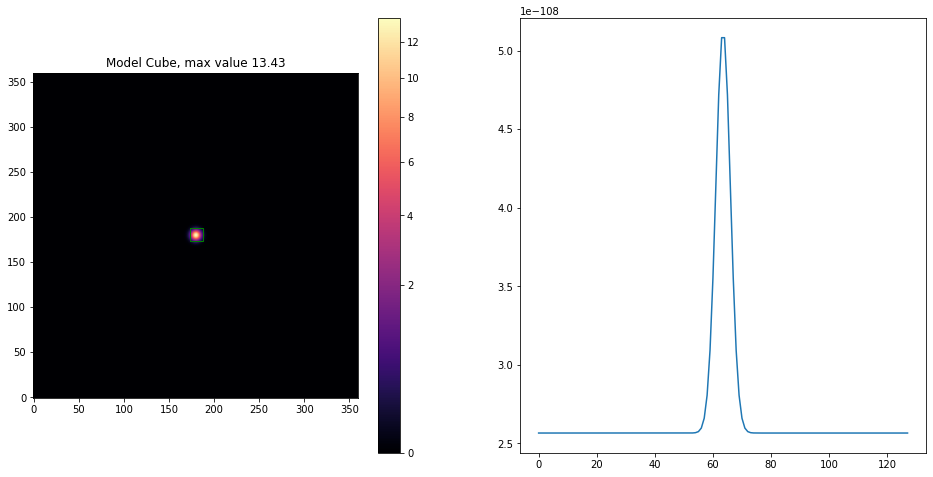

In [3]:
data_dir = "models"
output_dir = "sims"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
i = 0
amp = 0.1
line_amp = 1.0
box = generate_gaussian(amp, line_amp, data_dir, i)

Run the two simulations


0%....10....20....30....40....50....60....70....80....90....100%
....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
2022-06-08 10:27:34	WARN	tclean::::casa	Warning! Non-zero values at the edge of the .pb image can cause unexpected aliasing effects! (found value 0.2603057026863098 at index [356, 179, 0, 0])

0%....10....20....30....40....50....60....70....80....90....100%
2022-06-08 10:27:57	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2247)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.
2022-06-08 10:27:59	WARN	simalma::::casa	saveinputs not available in casatasks, skipping saving simalma inputs
2022-06-08 10:28:05	WARN	simalma::simalma::casa	------------------------------------------------------------
2022-06-08 10:28:05	WARN	simalma::simalma::casa	Step 1: simulating 12m ALMA array
2022-06-08 10

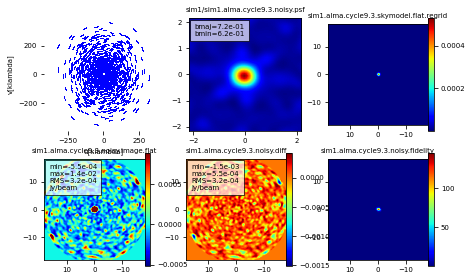

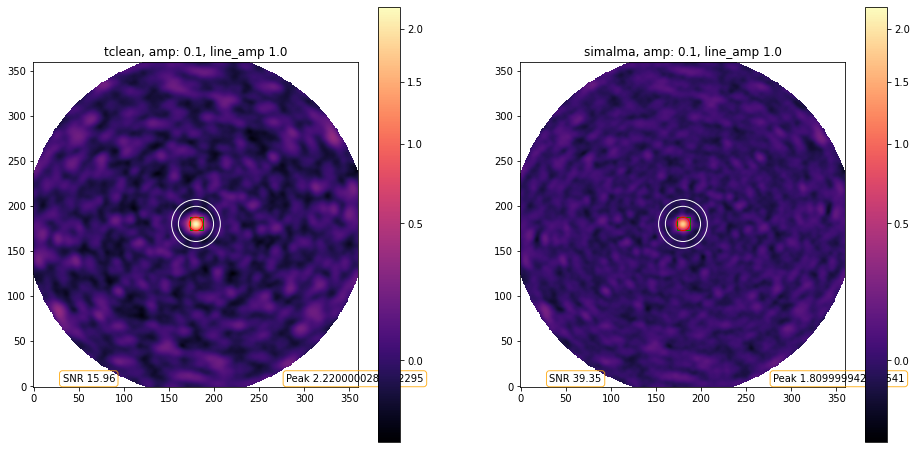

In [6]:
filename = os.path.join(data_dir, "gauss_cube_" + str(i) + ".fits")
project = "sim"
snr1 = simulator_tclean(output_dir, filename, project, amp, line_amp, box)
project = "sim1"
snr2 = simulator_simalma(output_dir, filename, project, amp, line_amp, box)
plotter(output_dir, amp, line_amp, box, snr1, snr2)